## Introduction ##

Cryo-electron microscopy (cryo-EM) is a powerful imaging technique that has transformed structural biology research by enabling high-resolution 3D reconstructions of complex biological macromolecules such as proteins. The process involves collection of tens of thousands of 2D images in a single run, which are then processed using specialized software to generate a detailed 3D model of electron density.

Despite the significant advancements in cryo-EM technology, current reconstruction algorithms, whether traditional or deep learning-based, are time-consuming and require hundreds of thousands of images to achieve high-resolution reconstructions. To accelerate the processing of cryo-EM data for downstream structural biology tasks, innovative methods for 3D reconstruction from 2D output projections are needed.

In this study, we focus on the task of single-particle analysis, where an individual particle is analyzed from 2D images and then reconstructed in 3D space. Our aim is to develop a reconstruction function that preserves the symmetries present in the data by being equivariant to the group SO(3) of 3D rotations. We investigate whether using SO(3)-equivariant neural networks, specifically spherical CNNs, can successfully perform cryo-EM reconstruction. We additionally measure potential improvements in performance and sample efficiency over previous algorithms without compromising the resolution of reconstruction.

## Related Work ##

One of the leading learning-based approaches for cryo-EM reconstruction is cryoDRGN, which leverages a deep generative model of 3D structure from single-particle 2D images [1]. CryoDRGN adopts an image-encoder-volume-decoder architecture, and the model is specified in the Fourier domain to relate 2D images as planar slices in 3D volume. This Fourier-based representation enables the model to efficiently capture detailed particle pose information from images. However, to achieve high-resolution reconstructions, cryoDRGN still requires a large number of images, often in the order of hundreds of thousands. While cryoDRGN is capable of handling heterogeneous reconstructions, where the protein may exhibit different conformational changes across images, we will evaluate its efficacy in our homogeneous reconstruction setting, where we assume all 2D images capture the protein at the same conformational state.
 
Although not used from cryo-EM reconstruction, previous work has demonstrated that 3D object structure and pose can be predicted successfully from a single image using SO(3)-equivariant features [2]. The method, known as Image2Sphere, initially utilizes a vanilla convolutional neural network to extract features that are then projected onto a half-sphere. Next, the projected filter undergoes spherical convolution, which results in a signal that is equivariant to SO(3) rotation. Finally, a group convolution yields a distribution over SO(3) parameterized in the Fourier domain. We plan to employ a similar methodology for our task, but instead of single-image reconstruction, we will focus on multi-view reconstruction.

## Background ##

This project will involve using group convolutions to build up a convolutional neural network which operates on spherical embeddings. This includes concepts surrounding convolutions on SO(3) covered in class (e.g. applying the fourier transform on spherical harmonics). It also includes researching topics beyond the scope of the class such as projections of 2D images onto S2, and building equivariant models which operate directly on spherical embeddings. This project also involves extensive study of 3D reconstruction methods which are outside the scope of the class. Additionally, integrating equivariant methods with the reconstruction algorithms involves combining ideas from symmetry and representation theory with traditional computer vision and graphics methods. 

## Methods ##

### High-level Mathematical Formulation

Let $P$ be the electron density representation of a protein. Particularly, $P: \mathbb{R}^3 \rightarrow \mathbb{R}$ specifies a density at every point in space. Note that proteins can also be represented as graph structures embedded in $\mathbb{R}^3$, but we focus on the electron density representation since this is used to generate the inputs to our model, and is, ultimately, the desired output of the reconstruction model. Also, note that $P$ is very sparse/localized, as each protein has finite volume.

Let $c$ be the canonical orthographic projection from $\mathbb{R}^3$ to $\mathbb{R}^2$. For example, we implement $c$ as 
$$c = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}.$$
Then, we define a *random projection* of $P$ as $c(R(P))$ where $R \in SO(3)$ is a uniformly random rotation. Note that in practice, each random projection is represented as a 2D image (with fixed resolution) rather than as a point cloud. 

Our model takes as input $m$ random projections of $P$, and aims to reconstruct $P$. So, we define $c_m$ as the operator which takes as input some 3D electron density map and outputs $m$ random projections (as images) via $cR$. And so, our model aims to reconstruct $P$ from $c_m(P)$. Note that although $c_m$ has been defined in a randomized way, henceforth we treat $c_m$ as a deterministic operator (e.g. we consider a single instance of $c_m$ that would be used for training/inference).


### Experimental Techniques

We use the Protein Data Bank (PDB) to collect experimentally-determined cryo-EM structures (13375 single-particle data points). For each data point, there is an electron density map in the form of a 3D array as well as 3D coordinates for every residue in the protein. We will use the 3D electron density map to generate $m$ random projections and subsequently add Gaussian noise to the projection images, for use as the 2D images from which we will do reconstruction. The generation and application of synthetic data in this manner for cryo-EM reconstruction algorithm development is common in prior work.


#### Data Generation ####

In [1]:
import pickle
import src.models as models
import src.so3_utils as utils
import numpy as np
import src.projection as proj
import time
import e3nn
from e3nn import o3
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'healpy'

We load the data as a dictionary of the form `{pdb_id: {"3D_map": np.ndarray, "structure": np.ndarray}}`. This dictionary is generated from the raw data csvs (downloaded from rcsb.org) using data_extraction.py

In [ ]:
with open('processed_dataset.pickle', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

We then iterate through the dictionary, normalize each electron density map by subtracting the minimum element and dividing by the median, and store each entry as a point density array (not storing background pixels with no relevant information).

In [8]:
pdas = {}

for pdb_id, metadata in content.items():
    # get the 3D electron density map 
    edm = metadata["3D_map"] 
    
    # we skip over ill-formed/noisy data 
    if np.count_nonzero(edm) > 0.5 * np.size(edm):
        continue
    
    # normalize edm and convert to PDA representation
    normalized_edm = proj.normalize_edm(edm)
    pda = proj.point_density_array(normalized_edm)

    pdas[pdb_id] = pda

6GL7
Normalization: 11.395614862442017
PDA: 6.210445880889893
6GOV
Normalization: 2.3676750659942627
PDA: 1.2506520748138428


We then generate $m$ (for now, we take $m=3$) random projections of each PDA. We save these projections into a pickle.

Random projection: 24.43211579322815


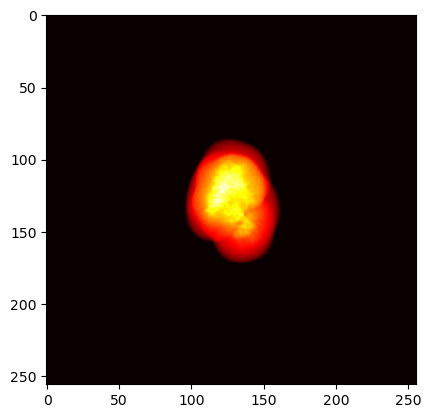

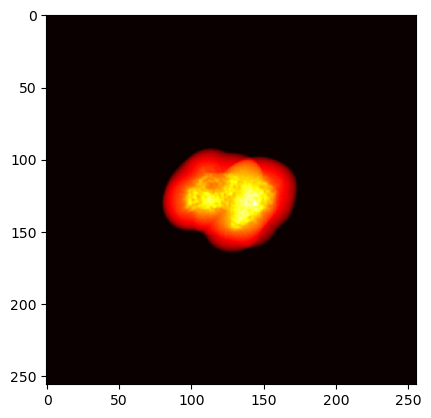

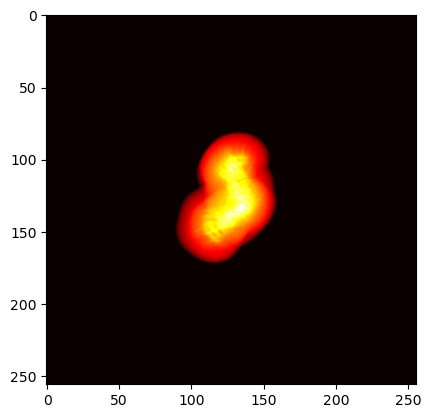

Random projection: 6.664622783660889


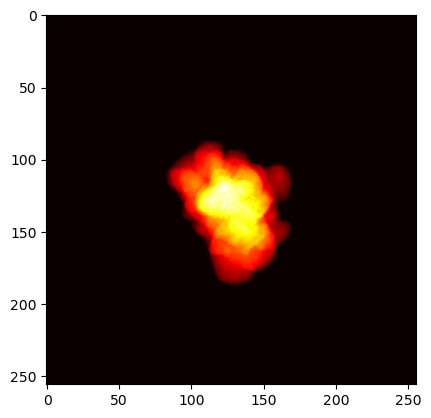

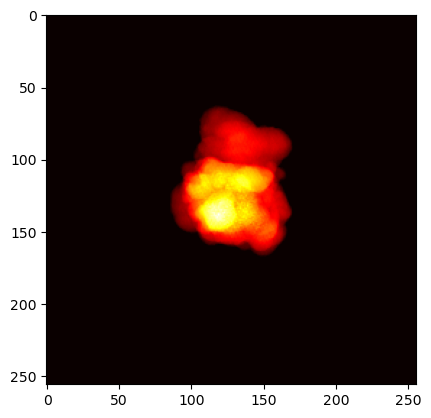

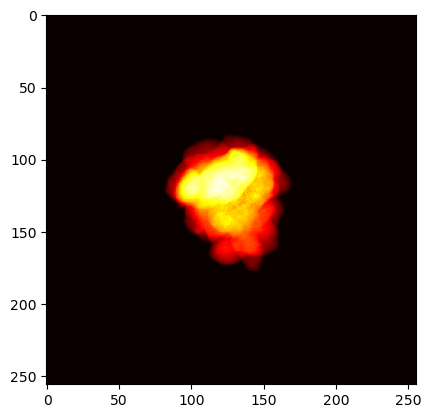

In [9]:
shape = (256, 256)
projection_dict = {}
m = 3

for pdb_id, pda in pdas.items():
    # generate m random 2D projections of the protein
    random_projs = proj.random_projection_pda(pda, shape=shape, batch_size = m)

    # visualize the projections
    print(f"Protein: {pdb_id}")
    for projection in random_projs:
        proj.visualize_projection(projection)
    
    projection_dict[pdb_id] = random_projs

In [10]:
# save the generated projections
with open('projections.pickle', 'wb') as handle:
    pickle.dump(projection_dict, handle)

#### Projection onto Half-Sphere ####

Our methodology involves projecting each 2D image onto a half sphere as shown in the code below. Let us call this spherical projection $s$. These spherical signals are an input to a spherical CNN from which we extract features that are spatially local. Let us call the function learned by the spherical CNN $f$. These learned spherical embeddings should encode pose information, and we plan to experiment with the architecture and parameters of the spherical CNN such that this pose information is well captured. 

Particularly, we hope to show that these embeddings are empirically $SO(3)$-equivariant. Let $R \in SO(3)$ be a 3D rotation. Then, for the embeddings to be empirically equivariant, we would have $f(s(c_m(RP))) = Rf(s(c_m(P)))$. That is a rotation $R$ of the protein before imaging should result in the same rotation $R$ of the corresponding embedding in the learned spherical latent space. In particular, this means that we should be able to garner information about the relative pose of several 2D images from their spherical embeddings since the total operator $fsc_m$ is (empirically) equivariant.  

Note that since our imaging and projection ($sc_m$) is fundamentally not $SO(3)$-equivariant, we are not looking for an $SO(3)$-equivariant $f$. Rather, we are looking to learn $f$ such that $fsc$ is approximately equivariant. 

In [11]:
with open('projections.pickle', 'rb') as pickle_file:
    projection_dict = pickle.load(pickle_file)

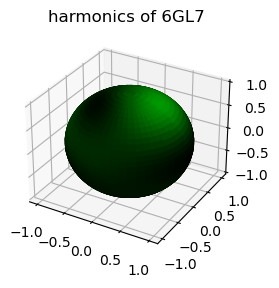

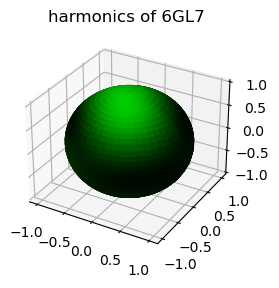

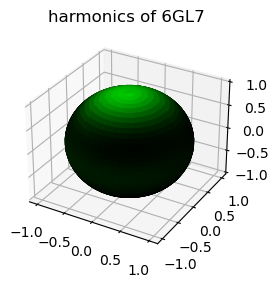

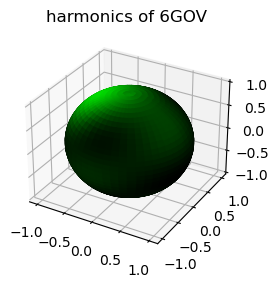

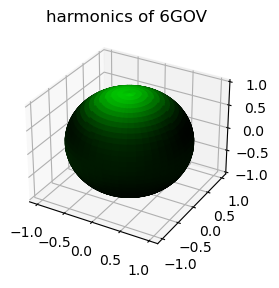

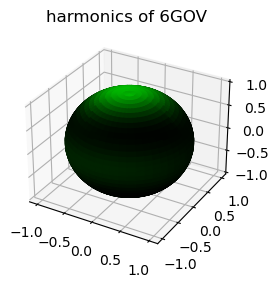

In [12]:
import torch
projector = proj.Image2SphereProjector(fmap_shape=(1,)+shape, sphere_fdim=1, lmax=4)
signals = []
for pdb_id, random_projs in projection_dict.items():
    for fmap in random_projs:
        fmap = torch.from_numpy(np.expand_dims(fmap, axis=0))
        signals.append(proj.visualize_spherical_projection(fmap.float(), projector, pdb_id))

#### Training Spherical CNN ####

We will train a network consisting of S2Conv, SO3Activation, and SO3Conv layers. This is an example of applying these layers (untrained).

In [13]:
lmax=4
s2_fdim=1
so3_fdim=16
s2_kernel_grid = proj.s2_healpix_grid(max_beta=np.inf, rec_level=1)
so3_kernel_grid = utils.so3_near_identity_grid()

s2_conv = models.S2Conv(s2_fdim, so3_fdim, lmax, s2_kernel_grid)
so3_act = e3nn.nn.SO3Activation(lmax, lmax, act=torch.relu, resolution=10)
so3_conv = models.SO3Conv(so3_fdim, 1, lmax, so3_kernel_grid)

/opt/miniconda3/envs/py3106/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [14]:
sample_signal = signals[0]
print(sample_signal.shape)

x = s2_conv(sample_signal)
x = so3_act(x)
convolved_embedding = so3_conv(x)

torch.Size([1, 1, 25])


In [15]:
print(convolved_embedding.shape)

torch.Size([1, 1, 165])


#### Reconstruction Algorithm ####

Once we have spherical embeddings for each 2D image encoding the pose of the image, we plan to use a fully connected network with equivariant linear layers. The output of this network will be a 3D electron density map, and our loss will be MSE with respect to the ground truth EDM. Before calculating MSE, we will align the predicted and ground truth EDMs with a sampling-based Monte Carlo approach.

#### Experiments ####

Our training regime involves using several proteins and randomly simulated projections of the 3D structures onto 2D images. We use simulated data because real cryo-EM image data is often un-processed and spans several terabytes to petabytes in size, which is impractical to use for training. Using simulated images with added noise allows for more efficient training and inference protocols while showing a proof-of-concept of our model architecture.Our model architecture will be based on spherical CNNs used in prior works, as mentioned previously.

During testing, we plan to run several experiments which vary m at inference time, allowing us to measure our model performance as a function of m. This will allow us to provide a tradeoff curve correlating data efficiency versus model accuracy. We also plan to run experiments to understand how our model performance is affected by the amount of noise in samples provided both at training and inference time. To assess the quality of reconstructions, we will compute how close our predicted structure is to the ground truth structure. We will also measure the resolution of our reconstruction for comparison to previous methods.

#### Conclusions ####

We hope to gain a better understanding of how data efficiency of cryo-EM reconstruction can be improved by using equivariant methods. We expect to see an improvement in data efficiency, with tradeoffs in model performance dependent on noise in image samples. We also hope to show how traditional reconstruction methods can be integrated with novel symmetry-preserving methods.

#### References ####

[1] https://www.nature.com/articles/s41592-020-01049-4

[2] https://arxiv.org/pdf/2302.13926.pdf